# Quality Complaints Classification

ML model to classify whether a quality complaint is valid or not.

In [25]:
import warnings
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from dython.nominal import associations
from sklearn.model_selection import train_test_split

from helpers import constants

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
cmap = plt.get_cmap('viridis')

## EDA

1. Converting the variables to categorical
2. Drop NA values
3. Summary statistics
4. Histograms
5. Statistical tests
6. Association matrix

In [26]:
df = pd.read_csv('db/dataset_encoded.csv', sep=',')
df.head()

,plant,storage,quantity,number_defects,sales,location,hybrid,treatment,result,reason
0,0,0,32000.0,250,250.0,0,0,0,False,Quebramento/tombamento de plantas
1,0,0,65000.0,250,250.0,1,0,0,False,Acamamento de plantas
2,0,0,65000.0,1050,1050.0,1,0,0,False,Acamamento de plantas
3,1,1,85.0,85,96.0,2,1,1,False,Quebramento/tombamento de plantas
4,2,2,245.0,78,133.0,3,2,1,False,Plantabilidade/Classificação de peneira


In [27]:
for cat_col in constants.CATEGORICAL_COLUMNS:
    df[cat_col] = df[cat_col].astype("category")

for num_col in constants.NUMERIC_COLUMNS:
    df[num_col] = df[num_col].astype("int32")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   plant           3986 non-null   category
 1   storage         3986 non-null   category
 2   quantity        3986 non-null   int32   
 3   number_defects  3986 non-null   int32   
 4   sales           3986 non-null   int32   
 5   location        3986 non-null   category
 6   hybrid          3986 non-null   category
 7   treatment       3986 non-null   category
 8   result          3986 non-null   bool    
 9   reason          3985 non-null   category
dtypes: bool(1), category(6), int32(3)
memory usage: 99.0 KB


In [29]:
df.dropna(inplace=True)
df.describe()

,quantity,number_defects,sales
count,3985.000000,3985.000000,3985.000000
mean,3000.481054,104.998243,243.010790
std,12544.750925,148.849452,262.360002
min,0.000000,0.000000,-50.000000
25%,35.000000,20.000000,61.000000
50%,100.000000,50.000000,155.000000
75%,370.000000,128.000000,320.000000
max,168750.000000,1555.000000,1979.000000


In [30]:
counts = df["result"].value_counts()

fig1 = px.bar(
    x=counts.index,
    y=counts.values,
    color=counts.values,
    color_continuous_scale="viridis",
    labels={"x": "Result", "y": "Count"},
    title="Histogram of Results",
)

fig1.update_traces(text=counts.values, textposition="outside")
fig1.update_yaxes(range=[0, max(counts.values) * 1.1])
fig1.update_layout(bargap=0.5, width=600, height=400, coloraxis_showscale=False)

fig1.show()

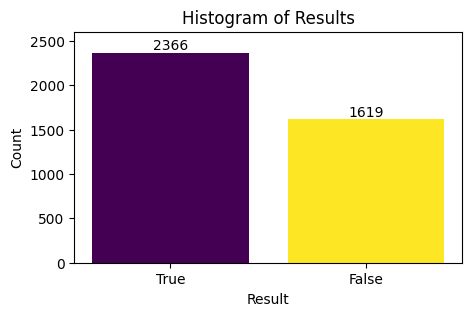

In [31]:
plt.figure(figsize=(5, 3))
colors = cmap(np.linspace(0, 1, len(counts)))

bars = plt.bar(counts.index.astype(str), counts.values, color=colors)

plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Histogram of Results")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha="center", va="bottom")
plt.ylim(0, max(counts.values) * 1.1)
plt.show()

In [32]:
counts = df["reason"].value_counts()

fig2 = px.bar(
        x=counts.index[:5],
        y=counts.values[:5],
        text=counts.values[:5],
        color=counts.values[:5],
        color_continuous_scale="viridis",
        labels={"x": "Reason", "y": "Count"},
        title="Top 5 reasons for all complaints",
    )

fig2.update_traces(text=counts.values, textposition="outside")
fig2.update_yaxes(range=[0, max(counts.values) * 1.2])
fig2.update_layout(bargap=0.5, width=720, height=400, coloraxis_showscale=False)
fig2.show()

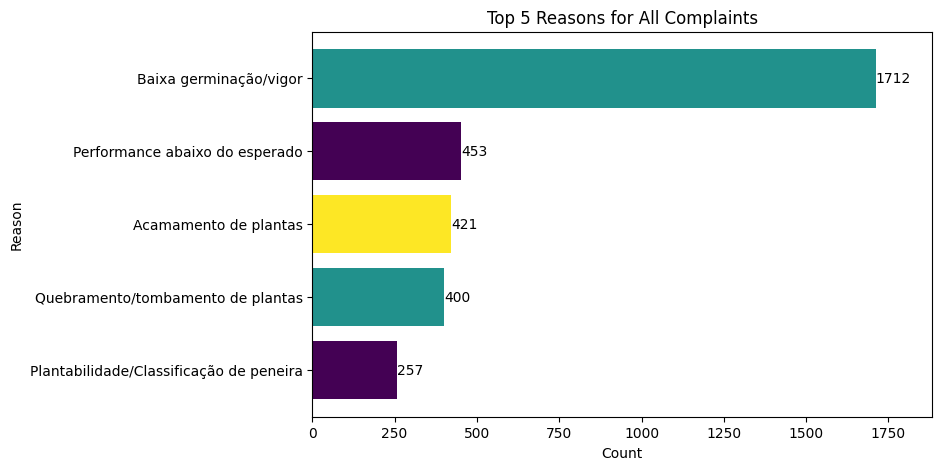

In [33]:
counts = counts.sort_values(ascending=True).tail(5)

plt.figure(figsize=(8, 5))
colors = cmap(np.linspace(0, 1, 3))

bars = plt.barh(counts.index, counts.values, color=colors)

plt.ylabel('Reason')
plt.xlabel('Count')
plt.title('Top 5 Reasons for All Complaints')


for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, int(bar.get_width()), va='center')

plt.xlim(0, max(counts.values) * 1.1)

plt.show()

In [34]:
bar1 = go.Bar(
    name="True",
    x=df[df["result"] == True]["reason"].value_counts().index[:1],
    y=df[df["result"] == True]["reason"].value_counts().values[:1],
    text=df[df["result"] == True]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#440154",
)

bar2 = go.Bar(
    name="False",
    x=df[df["result"] == False]["reason"].value_counts().index[:1],
    y=df[df["result"] == False]["reason"].value_counts().values[:1],
    text=df[df["result"] == False]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#31688e"
)

fig3 = go.Figure(data=[bar1, bar2])

fig3.update_layout(
    barmode="group",
    title_text="Top reason for complaints by result",
    bargap=0.5,
    width=600,
    height=400,
)

fig3.show()

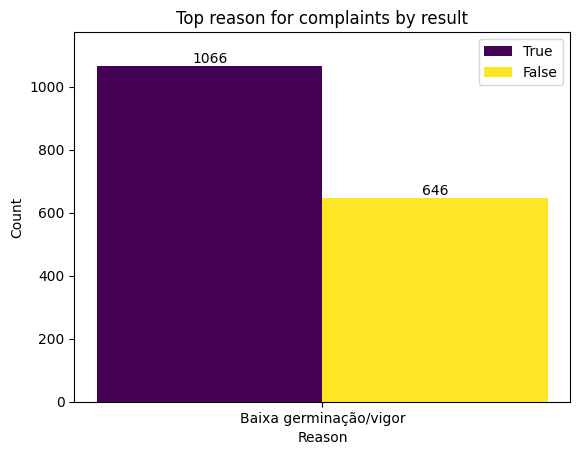

In [35]:
colors = cmap(np.linspace(0, 1, 2))

x1 = np.arange(1)  # x1 is now an array of indices
y1 = df[df["result"] == True]["reason"].value_counts().values[:1]
bars1 = plt.bar(x1, y1, color=colors[0], align='edge', width=-0.4)

x2 = np.arange(1)  # x2 is now an array of indices
y2 = df[df["result"] == False]["reason"].value_counts().values[:1]
bars2 = plt.bar(x2, y2, color=colors[1], align='edge', width=0.4)

plt.xlabel('Reason')
plt.ylabel('Count')
plt.title('Top reason for complaints by result')
plt.legend(['True', 'False'])

plt.xticks(x1, df[df["result"] == True]["reason"].value_counts().index[:1])

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')


plt.ylim(0, max(y1) * 1.1)

plt.show()

## Statistical tests
### Chi-Squared Test

The Chi-Squared Test of Independence is used to determine if there is a significant association between two categorical variables. The null hypothesis (H0) is that the variables are independent, and the alternative hypothesis (H1) is that the variables are dependent.

The formula is:
$$\chi^2 = \sum \frac {(O - E)^2}{E}$$

Where $O$ is the observed frequency and $E$ is the expected frequency.

In [36]:
# Pretty print
colors = {'PURPLE':'\033[95m', 'CYAN':'\033[96m', 'DARKCYAN':'\033[36m', 'BLUE':'\033[94m',
          'GREEN':'\033[92m', 'YELLOW':'\033[93m', 'RED':'\033[91m','BOLD':'\033[1m',
          'UNDERLINE':'\033[4m', 'END':'\033[0m'}

In [37]:
categorical_variables = constants.CATEGORICAL_COLUMNS
alpha = 0.05

for var in categorical_variables:
    contingency_table = pd.crosstab(df["result"], df[var])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print('Chi-Squared Test of Independence for variable -> ' + colors['UNDERLINE'] + var + colors['END'])
    print(colors['BOLD'] + 'p-value' + colors['END'] + ' = ' + str(p))
    if p <= alpha:
        print(colors['GREEN'] +"Dependent (reject H0)\n" + colors['END'])
    else:
        print(colors['RED'] +"Independent (H0 holds true)\n" + colors['END'])

Chi-Squared Test of Independence for variable -> plant
p-value = 3.4439898088286545e-27
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> storage
p-value = 3.179461176926628e-21
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> location
p-value = 1.0821698856832491e-63
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> treatment
p-value = 0.0001274017720288051
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> hybrid
p-value = 9.741533614237658e-79
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> reason
p-value = 1.8386698047731776e-23
Dependent (reject H0)



### Cramer's V
Cramer's V is a scaled version of the chi-squared test statistic $\chi^2$, which ranges from 0 to 1. It is used to measure the strength of association between two nominal variables. The value of Cramer's V ranges from 0 to 1, where 0 indicates no association between the variables, and 1 indicates a strong association between the variables.

The formula is:
$$Cramer's V = \sqrt{\chi^2/(n\cdot(k-1))}$$

Where $\chi^2$ is the chi-squared test statistic, $n$ is the number of observations, and $k$ is the number of categories in the contingency table.

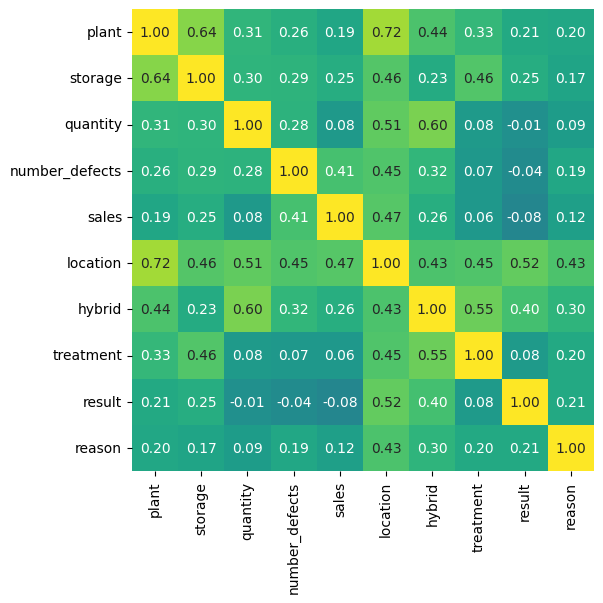

In [38]:
cramers_v = associations(df, figsize=(6, 6), cbar=False, cmap="viridis")

In [44]:
df_associations = pd.DataFrame(cramers_v["corr"])
sorted_associations = pd.DataFrame(
    df_associations["result"].sort_values(ascending=False)[1:6]
)

fig4 = px.bar(
    sorted_associations,
    y="result",
    x=sorted_associations.index,
    color="result",
    color_continuous_scale="viridis",
    title="Top 5 Ranked Associations with Result",
    labels={"index": "Variable", "result": "Cramér's V Score"},
)

fig4.update_yaxes(range=[0, max(sorted_associations["result"]) * 1.1])
fig4.update_traces(text=round(sorted_associations["result"], 3), textposition="outside")

fig4.show()

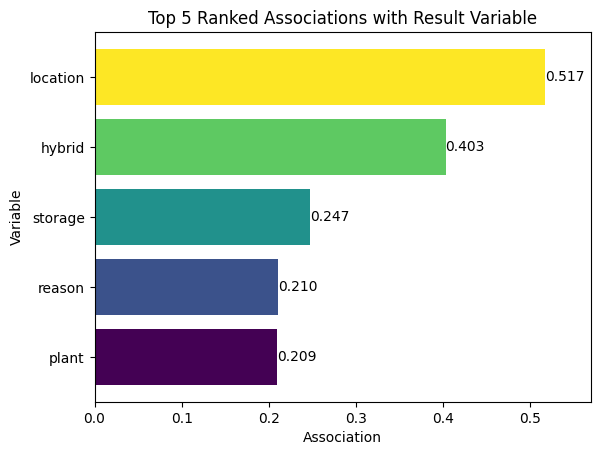

In [46]:
sorted_associations = sorted_associations.sort_values(by="result", ascending=True)

colors = cmap(np.linspace(0, 1, len(sorted_associations)))

bars = plt.barh(sorted_associations.index, sorted_associations["result"], color=colors)

plt.xlabel("Association")
plt.ylabel("Variable")
plt.title("Top 5 Ranked Associations with Result Variable")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left')
    

plt.xlim(0, max(sorted_associations["result"]) * 1.1)

plt.show()

## Model

### Splitting the data
The data is split into training and testing sets with a 80-20 ratio.

In [47]:
X = df.drop('result', axis=1)
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Encoding categorical variables
The categorical variables are encoded using the `CountEncoder` method from the `category_encoders` library.

In [52]:
encoder = ce.CountEncoder(cols=constants.CATEGORICAL_COLUMNS)

In [53]:
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

### LightGBM
LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed for speed and efficiency and can handle large datasets.

In [48]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [50]:
param_grid_lgbm = {
    'learning_rate': [0.05, 0.08, 0.1,],
    'max_depth': [1, 3, 5, 7, 10, 15, 20, 25, 30],
    'num_leaves': [7, 15, 31, 63, 127, 255, 511],
    'n_estimators': [10, 50, 100, 200, 500]
}

In [51]:
lgbm_classifier = lightgbm.LGBMClassifier(random_state=42)

In [ ]:
grid_search_lgbm = GridSearchCV(lgbm_classifier, param_grid_lgbm, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
grid_search_lgbm.fit(X_train_encoded, y_train)